## Wine Classification using K_means
    Auteur : Thierry SANDOZ and Stephen MONNET                        
    Date : 13.05.2020 
    Contenu : Essai de classification des différents vins blancs en utilisant un algorithme de K_means

In [1]:
from sys import path
path.append('functions')
from WineClassificationLib import distribution

import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import sys
import scipy.io as sio
import seaborn as sns
import itertools

## K_means
from sklearn.cluster import KMeans

## Mathematical functions
import math                # for exp()

## Optimizing a function
import scipy.optimize as opt

# Normalization 
from sklearn import preprocessing

# Data separation 
from sklearn.model_selection import train_test_split

## Ouverture des fichiers + Prétraitement des données
Les données sont enregistrées en format csv et celles-ci sont séparées par des ';'. La fonction read_csv de Pandas permet directement d'ouvrir un fichier et de stocker les différentes données sous forme de tableau. Le tableau présent ci-dessous permet de visualiser un aperçu du contenu des ces données. Le prétraitement des données est détaillé dans le fichier WineClassification.ipynb

In [2]:
dataWine = pd.read_csv("data/winequality-white.csv", sep=';')

## Affichage des 5 premières lignes de données
display(dataWine.head(n=5))

## Affichage du nombre de données
nb_data = len(dataWine)
print('Le nombre de données présentes dans le fichier (taille du dataset) est de :', nb_data)

## Séparation des données en différentes classes : 1, 2, 3, 4 = mauvais, 5 = assez bon, 6 = bon, 7 = très bon, 8, 9, 10 => excellent
bins = [3,4,5,6,7,9]
quality_labels=[0,1,2,3,4]
num_labels = len(quality_labels) ## Number of labels
dataWine['quality_categorical'] = pd.cut(dataWine['quality'], bins=bins, labels=quality_labels, include_lowest=True)

# For each feature find the data points with extreme high or low values
outliers = []
features_raw = dataWine.drop(['quality', 'quality_categorical'], axis = 1)
quality_raw = dataWine['quality_categorical']

for feature in features_raw.keys():

    Q1 = np.percentile(features_raw[feature], q=25)

    Q3 = np.percentile(features_raw[feature], q=75)
    
    interquartile_range = Q3 - Q1
    step = 1.5 * interquartile_range
    
    #print("Data points considered outliers for the feature '{}':".format(feature))
    #display(dataWine[~((dataWine[feature] >= Q1 - step) & (dataWine[feature] <= Q3 + step))])

    outliers = outliers + list(features_raw[~((features_raw[feature] >= Q1 - step) & (features_raw[feature] <= Q3 + step))].index)
    
    # Remove the outliers, if any were specified
    good_data = features_raw.drop(features_raw.index[outliers]).reset_index(drop = True)
    good_quality = quality_raw.drop(quality_raw.index[outliers]).reset_index(drop = True)
    
print("Nb data before removing the outliers :", len(dataWine))
print("Nb data after removing the outliers :", len(good_data))

## Normalize the features between 0 and 1
x = good_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
good_data = pd.DataFrame(x_scaled, columns=good_data.columns)

## Diplay the first five row of the datas
display(good_data.head(n=5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Le nombre de données présentes dans le fichier (taille du dataset) est de : 4898
Nb data before removing the outliers : 4898
Nb data after removing the outliers : 4011


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.550,0.469136,0.553191,0.939252,0.527273,0.551282,0.636752,0.935354,0.232877,0.425926,0.068966
1,0.375,0.543210,0.510638,0.046729,0.600000,0.153846,0.474359,0.463973,0.643836,0.500000,0.189655
2,0.825,0.493827,0.638298,0.294393,0.618182,0.358974,0.324786,0.538047,0.589041,0.407407,0.293103
3,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621
4,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621


### Séparation des données en 2 sets
Pour déterminer si les résultats obtenus par l'algorithme sont bons, il est important de séparer les données en 2 sets de données. Le premier est le set d'entraînement. Il représente 80% du set complet et est celui qui permet d'entraîner l'algorithme de ML. Le deuxième est un set de test qui permettra d'observer les résultats obtenus sur des données n'ayant pas été utilisée pour l'entraînement. Celui-ci représente 20% du set complet. La fonction "train_test_split" de sklearn permet de réaliser cette division en 2 sets de manière aléatoire. Dans celle-ci on peut spécifier la taille du test set.

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(good_data, 
                                                    good_quality, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 3208 samples.
Testing set has 803 samples.


## Visualisation de la répartition des données
Pour déterminer si un algorithme de clustering est adéquat pour résoudre ce problème, on affiche la répartition des différentes données. On donne ensuite une couleur à chacun des points en fonction de la quality qui lui est attribuée pour visualiser quelle est leur répartition. On se rend compte que l'algorithme n'est pas adéquat pour calssifier les différentes données.

c:\users\thierry\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


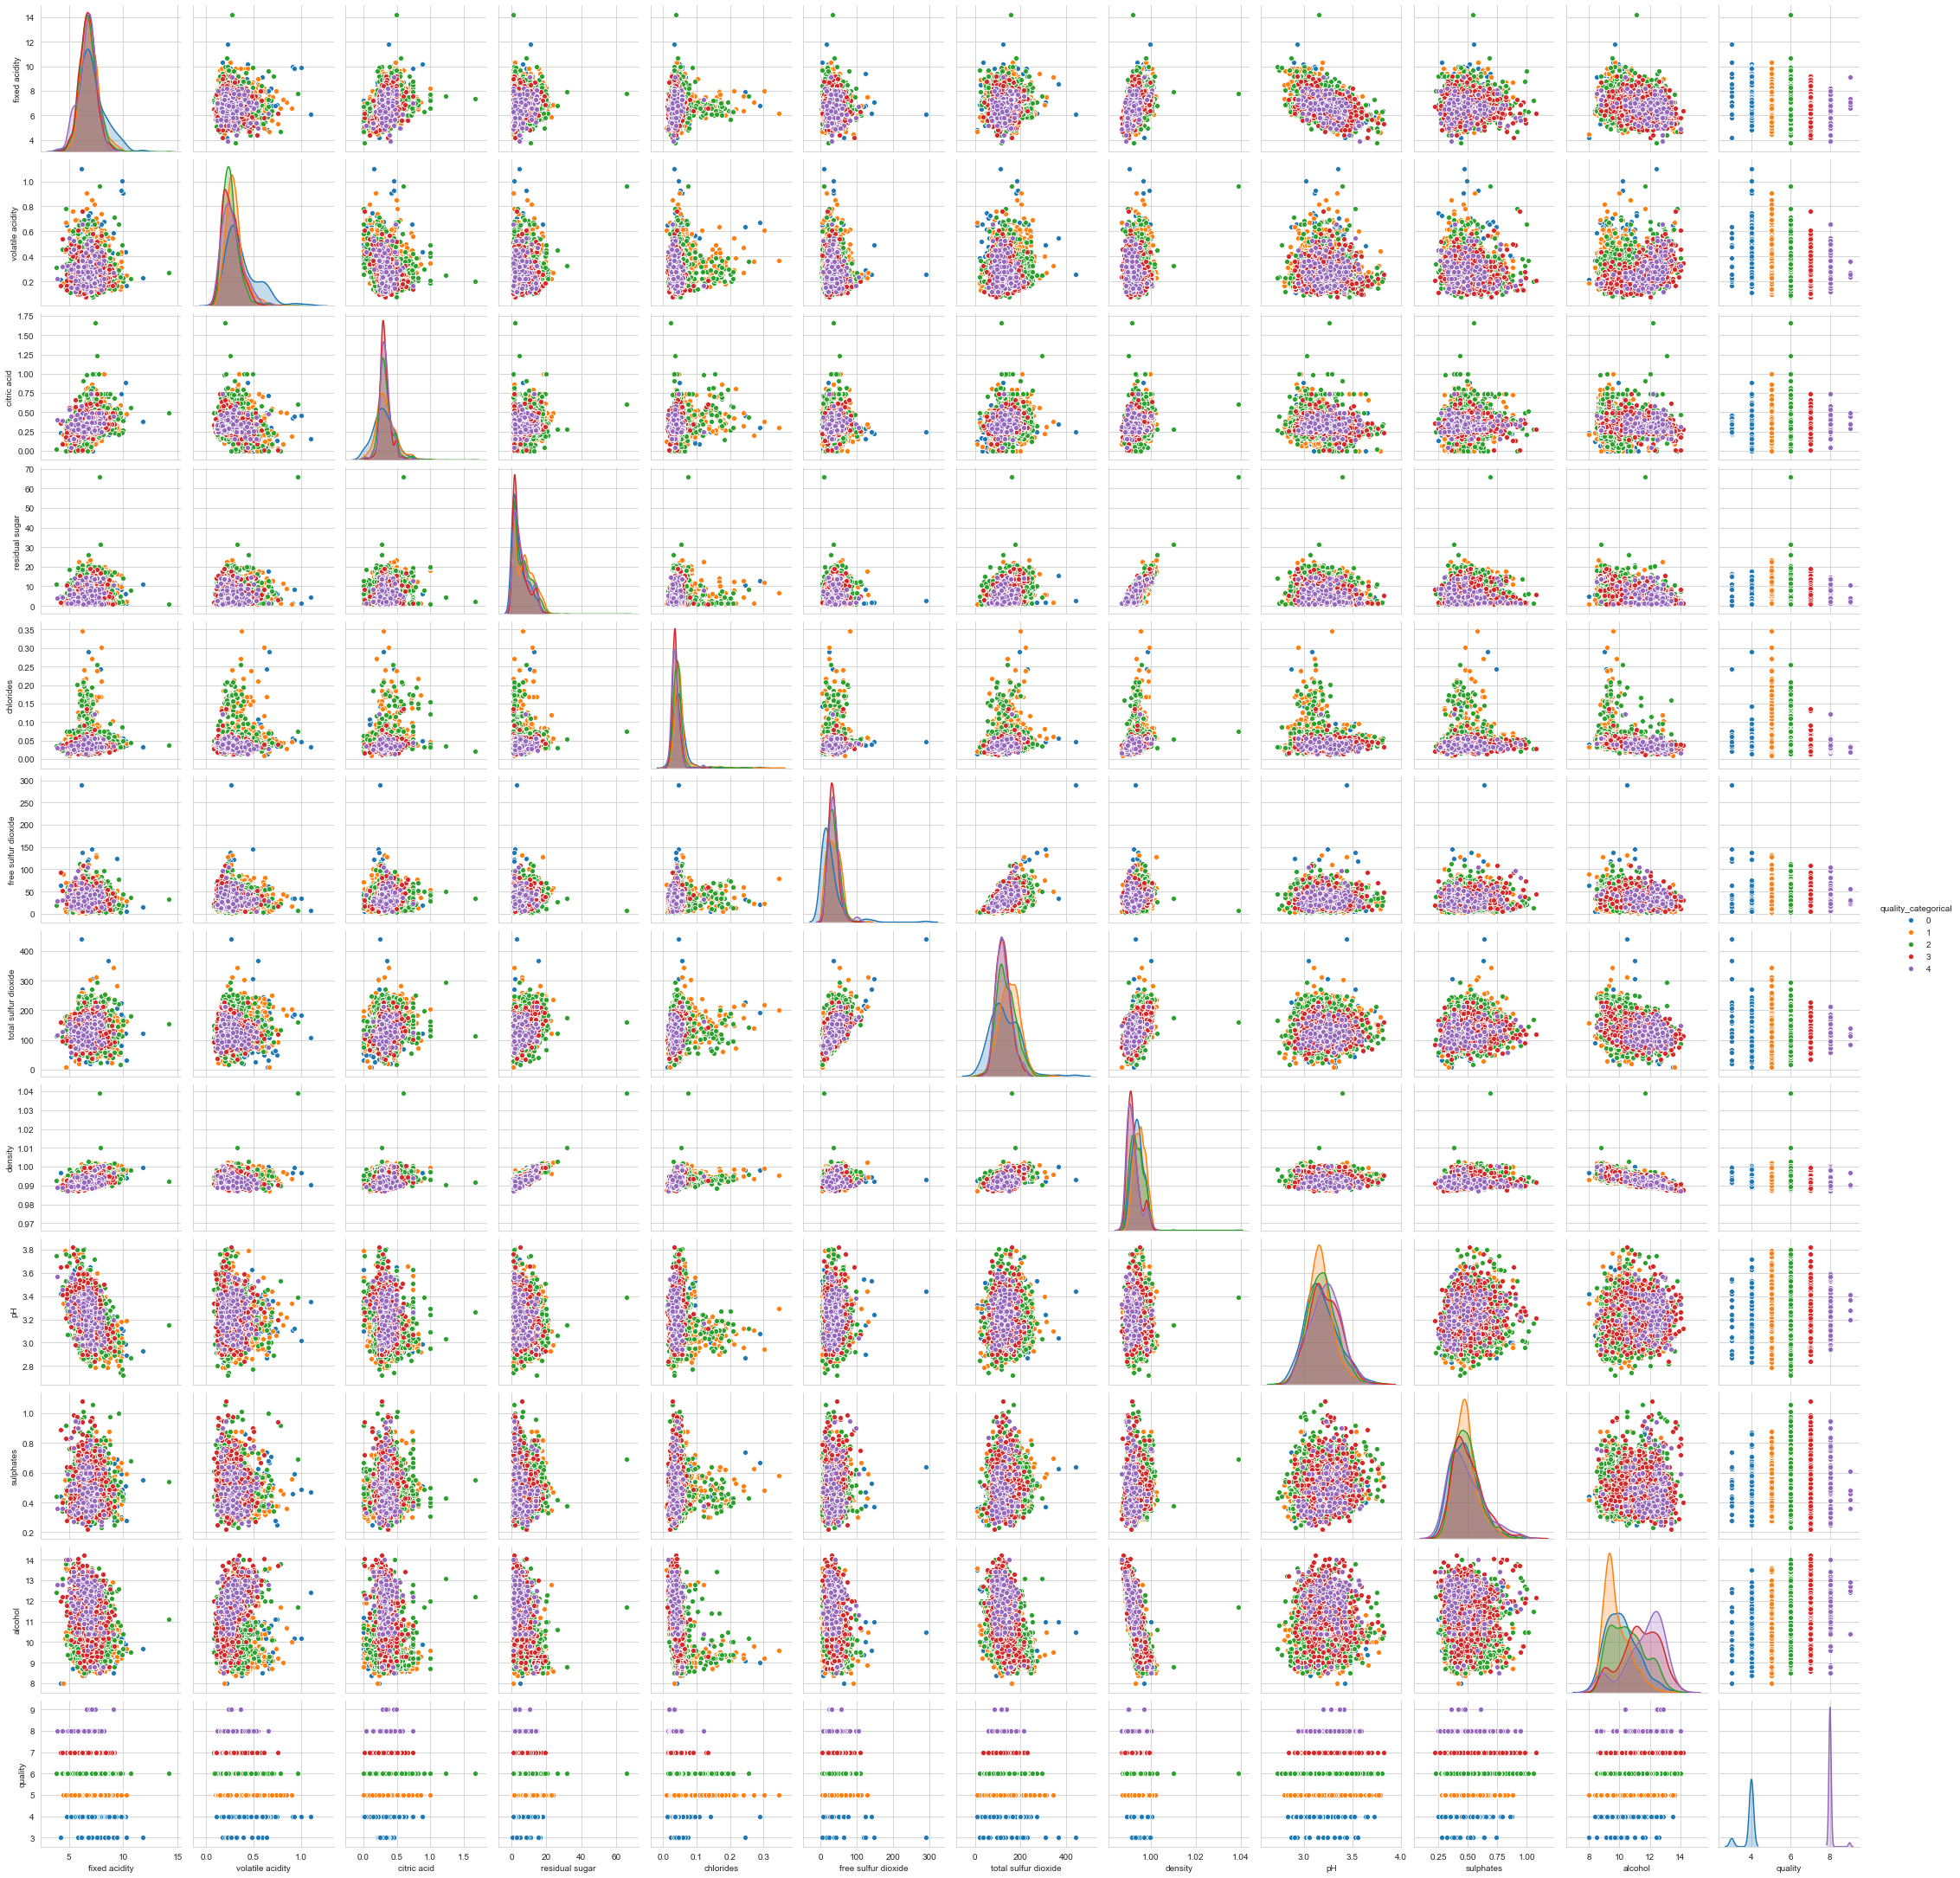

In [4]:
sns.set_style('whitegrid')
sns_plot = sns.pairplot(dataWine, hue='quality_categorical')
plt.show()

### Séparation des données en 2 sets
Pour déterminer si les résultats obtenus par l'algorithme sont bons, il est important de séparer les données en 2 sets de données. Le premier est le set d'entraînement. Il représente 80% du set complet et est celui qui permet d'entraîner l'algorithme de ML. Le deuxième est un set de test qui permettra d'observer les résultats obtenus sur des données n'ayant pas été utilisée pour l'entraînement. Celui-ci représente 20% du set complet. La fonction "train_test_split" de sklearn permet de réaliser cette division en 2 sets de manière aléatoire. Dans celle-ci on peut spécifier la taille du test set.

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(good_data, 
                                                    good_quality, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

## Convert to numpy array
X_train = np.array(X_train.values)
y_train = np.array(y_train.values)
y_train = np.squeeze(np.array([y_train])) 

X_test = np.array(X_test.values)
y_test = np.array(y_test.values)
y_test = np.squeeze(np.array([y_test])) 


Training set has 3208 samples.
Testing set has 803 samples.


In [6]:
num_examples = X_train.shape[0]
num_features = X_train.shape[1]

print('nb examples :', num_examples)
print('nb features :', num_features)
print('nb labels :', num_labels)

nb examples : 3208
nb features : 11
nb labels : 5


### Fonctions permettant l'implémentation de l'algorithme de K-means

In [ ]:
def findClosestCentroids(X, centroids) :

    K = centroids.shape[0]
    idx = np.zeros((X.shape[0],1))
    temp = np.zeros((centroids.shape[0],1))
    
    for i in range(X.shape[0]):
        for j in range(K):
            dist = X[i,:] - centroids[j,:]
            length = np.sum(dist**2)
            temp[j] = length
        idx[i] = np.argmin(temp)+1

    return idx

In [8]:
def computeCentroids(X, idx, K):
    m, n = X.shape[0],X.shape[1]
    centroids = np.zeros((K,n))
    count = np.zeros((K,1))
    
    for i in range(m):
        index = int((idx[i]-1)[0])
        centroids[index,:]+=X[i,:]
        count[index]+=1
    
    return centroids/count

In [9]:
def plotKmeans(X, centroids, idx, K, num_iters):

    m,n = X.shape[0],X.shape[1]
    
    fig, ax = plt.subplots(nrows=num_iters,ncols=1,figsize=(6,36))
    
    for i in range(num_iters):    
        color = "rgb"
        for k in range(1,K+1):
            grp = (idx==k).reshape(m,1)
            ax[i].scatter(X[grp[:,0],0],X[grp[:,0],1],c=color[k-1],s=15)
        ax[i].scatter(centroids[:,0],centroids[:,1],s=120,marker="x",c="black",linewidth=3)
        title = "Iteration Number " + str(i)
        ax[i].set_title(title)
        
        # Compute the centroids mean
        centroids = computeCentroids(X, idx, K)
        
        # assign each training example to the nearest centroid
        idx = findClosestCentroids(X, centroids)
    
    plt.tight_layout()
    
    return

In [10]:
def kMeansInitCentroids(X, K):
    m,n = X.shape[0], X.shape[1]
    centroids = np.zeros((K,n))
    
    for i in range(K):
        centroids[i] = X[np.random.randint(0,m+1),:]
        
    return centroids

In [11]:
def runKmeans(X, initial_centroids,num_iters,K):
    
    idx = findClosestCentroids(X, initial_centroids)
    
    for i in range(num_iters):
        
        # Compute the centroids mean
        centroids = computeCentroids(X, idx, K)
    # assign each training example to the nearest centroid
        idx = findClosestCentroids(X, initial_centroids)
        
    return centroids, idx

### Test de l'implémentation de l'algorithme de K-means
Ce test permet de visualiser si les résultats obtenus avec l'algorithme python correspondent à ceux implémentés dans matlab

In [12]:
##mat = sio.loadmat("ex7data2.mat")
##X = mat["X"]
##
##K = 3
##initial_centroids = np.array([[3,3],[6,2],[8,5]])
##idx = findClosestCentroids(X, initial_centroids)
##print("Closest centroids for the first 3 examples:\n",idx[0:3])
##
##centroids = computeCentroids(X, idx, K)
##print("Centroids computed after initial finding of closest centroids:\n", centroids)
##
##max_iters = 10;
##
##centroids = kMeansInitCentroids(X, K)
##idx = findClosestCentroids(X, centroids)
##plotKmeans(X, centroids,idx, K,10)